In [3]:
%run preprocessing.ipynb

In [4]:
%run temporal_preprocess.ipynb

100%|██████████| 6/6 [04:42<00:00, 47.16s/it]


                       Feature  Importance
0                       ged_sb    0.113809
1               decay_ged_ns_1    0.098164
2      sptime_dist_k001_ged_ns    0.054703
3       splag_1_decay_ged_sb_1    0.035678
4      sptime_dist_k001_ged_os    0.032818
5       sptime_dist_k10_ged_ns    0.029221
6       sptime_dist_k10_ged_os    0.025554
7        sptime_dist_k1_ged_ns    0.024370
8           wdi_nv_agr_totl_kd    0.023648
9              spei_48_detrend    0.021733
10  ged_sb_decay_12_time_since    0.020582
11           spei1_gsm_detrend    0.019496
12                   ged_gte_1    0.018472
13       mov_avg_6_ged_best_sb    0.016851
14       mov_sum_6_ged_best_sb    0.016176
15       sptime_dist_k1_ged_sb    0.015143
16                treelag_2_ns    0.014533
17                treelag_2_os    0.014492
18                treelag_1_ns    0.014380
19                treelag_1_os    0.014347
20             spei1_gs_prev10    0.013061
21        spei1_gs_prev10_anom    0.012437
22      spt

In [5]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [6]:
print(top_50_features)

['ged_sb', 'decay_ged_ns_1', 'sptime_dist_k001_ged_ns', 'splag_1_decay_ged_sb_1', 'sptime_dist_k001_ged_os', 'sptime_dist_k10_ged_ns', 'sptime_dist_k10_ged_os', 'sptime_dist_k1_ged_ns', 'wdi_nv_agr_totl_kd', 'spei_48_detrend', 'ged_sb_decay_12_time_since', 'spei1_gsm_detrend', 'ged_gte_1', 'mov_avg_6_ged_best_sb', 'mov_sum_6_ged_best_sb', 'sptime_dist_k1_ged_sb', 'treelag_2_ns', 'treelag_2_os', 'treelag_1_ns', 'treelag_1_os', 'spei1_gs_prev10', 'spei1_gs_prev10_anom', 'sptime_dist_k10_ged_sb', 'sptime_dist_k001_ged_sb', 'ged_sb_tlag_1_splag_1', 'tlag1_spei1_gsm', 'sptime_dist_k1_ged_os', 'mov_avg_12_ged_best_sb', 'mov_sum_12_ged_best_sb', 'ged_sb_tlag_1', 'mov_sum_36_ged_best_sb', 'spei1gsy_lowermedian_count', 'mov_avg_36_ged_best_sb', 'spei1_gsm_cv_anom', 'treelag_2_sb', 'treelag_1_sb', 'count_moder_drought_prev10', 'ged_sb_tlag_7', 'ged_sb_tlag_2', 'ged_sb_tlag_3', 'decay_ged_sb_25', 'tlag_12_crop_sum', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_9', 'ged_sb_tlag_8', 'tlag_12_harv

In [7]:
transformer_input

{-3.0866262643659366: array([[-0.023420489678843835, -0.1710966631236406, 4.764483199454078,
         ..., -0.023287209808973492, Timestamp('2018-01-01 00:00:00'),
         -3.0866262643659366],
        [-0.023420489678843835, -0.17109666312548963, 4.765135518014728,
         ..., -0.023287209808973492, Timestamp('2018-02-01 00:00:00'),
         -3.0866262643659366],
        [-0.023420489678843835, -0.17109666312723487, 4.765789709473987,
         ..., -0.023287209808973492, Timestamp('2018-03-01 00:00:00'),
         -3.0866262643659366],
        ...,
        [-0.023420489678843835, -0.17109666315383645, 4.79421636528054,
         ..., -0.023287209808973492, Timestamp('2021-08-01 00:00:00'),
         -3.0866262643659366],
        [-0.023420489678843835, -0.17109666315399072, 4.794948645917301,
         ..., -0.023287209808973492, Timestamp('2021-09-01 00:00:00'),
         -3.0866262643659366],
        [-0.023420489678843835, -0.1710966631541363, 4.795682771736554,
         ..., -0.0232

In [8]:
class TransformerDataset(Dataset):
    def __init__(self, data, date_encodings):
        self.data = data
        self.date_encodings = date_encodings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gid = list(self.data.keys())[idx]
        features = np.array(self.data[gid][:, :-2], dtype=np.float32)  # Exclude the last two columns if last is target and second last is date
        target = np.array(self.data[gid][:, -1], dtype=np.float32)
        dates = self.date_encodings[gid]
        return torch.tensor(features), torch.tensor(dates), torch.tensor(target)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x, dates):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TemporalTransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward=512, dropout=0.1):
        super(TemporalTransformerEncoder, self).__init__()
        self.input_embedding = nn.Linear(input_size, d_model // 2)
        self.pos_encoder = PositionalEncoding(d_model // 2, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model // 2, nhead=nhead // 2, dim_feedforward=dim_feedforward // 2, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model // 2, 1)

    def forward(self, x, dates):
        x = self.input_embedding(x)
        x = self.pos_encoder(x, dates)
        x = self.transformer_encoder(x)
        output = self.output_layer(x)
        return output.squeeze(-1)

In [16]:
# Proper DataLoader initialization
dataset = TransformerDataset(transformer_input, date_encodings)
train_set, val_set = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader([dataset[i] for i in train_set], batch_size=64, shuffle=True)
val_loader = DataLoader([dataset[i] for i in val_set], batch_size=64, shuffle=False)

# Initialize the model
model = TemporalTransformerEncoder(input_size=len(top_50_features), d_model=12, nhead=4, num_layers=16)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

import matplotlib.pyplot as plt

# Additional metrics for performance evaluation
def r_squared(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2.item()

# Lists to store loss and metrics for visualization
train_losses = []
val_losses = []
val_r2_scores = []

# Adjust the training loop to include validation metrics
for epoch in range(10):
    model.train()
    train_loss = 0
    for x, dates, target in train_loader:
        optimizer.zero_grad()
        output = model(x, dates)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    total_r2 = 0
    with torch.no_grad():
        for x, dates, target in val_loader:
            output = model(x, dates)
            loss = criterion(output, target)
            val_loss += loss.item()
            total_r2 += r_squared(target, output)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    avg_r2 = total_r2 / len(val_loader)
    val_r2_scores.append(avg_r2)

    if train_loss <= 0.4:
        print(f"Early Stoping at Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}") 
        break
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}')


Epoch: 1, Training Loss: 1.0131, Val Loss: 1.0032, Val R^2: 0.0097
Epoch: 2, Training Loss: 0.8221, Val Loss: 0.6207, Val R^2: 0.3831
Epoch: 3, Training Loss: 0.6019, Val Loss: 0.4628, Val R^2: 0.5401
Epoch: 4, Training Loss: 0.5050, Val Loss: 0.4013, Val R^2: 0.6012
Epoch: 5, Training Loss: 0.4513, Val Loss: 0.3497, Val R^2: 0.6527
Epoch: 6, Training Loss: 0.4164, Val Loss: 0.3248, Val R^2: 0.6773
Early Stoping at Epoch: 7, Training Loss: 0.3863, Val Loss: 0.3021, Val R^2: 0.6995


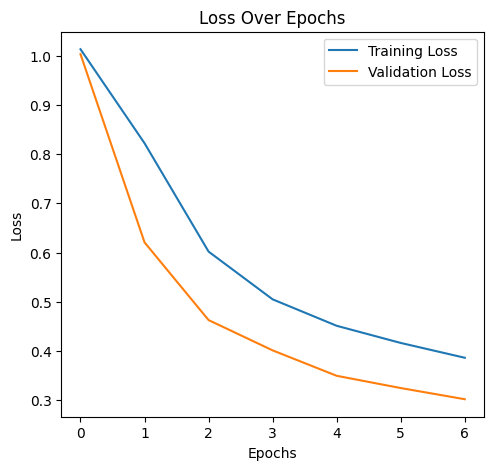

In [17]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

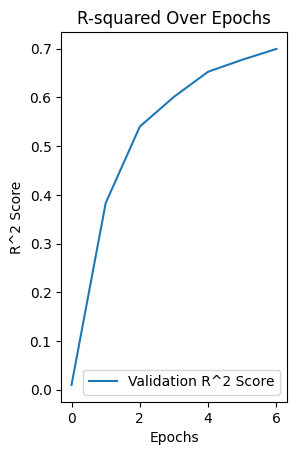

In [18]:
# Plotting R-squared values
plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Validation R^2 Score')
plt.title('R-squared Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()